# Quantum Optics NN Project: Inverse Design of Circuit Parameters from Wigner Functions

This Jupyter notebook provides a complete end-to-end workflow for the quantum optics hackathon project. The goal is to train a neural network (NN) to predict quantum circuit parameters (squeezing values, beam splitter angles/phases, and photon numbers) from images of Wigner functions representing non-Gaussian quantum states.

The notebook is divided into sections :

- Section 1: Import Libraries
- Section 2: Define Circuit Parameters and Bounds
- Section 3: Generate Training Data
- Section 4: Load and Explore Data
- Section 5: Prepare Data for PyTorch
- Section 6: Define the Neural Network Model
- Section 7: Train the Model




 We'll use:

MrMustard for simulating continuous-variable (CV) quantum circuits and generating Wigner functions.
NumPy for data handling and saving/loading.
PyTorch for building and training the NN (as per your preference).
Matplotlib for visualizations.

### Prerequisites

In [9]:
# !pip install numpy matplotlib torch
# !pip install "mrmustard @ git+https://github.com/XanaduAI/MrMustard.git"

## Section 1: Import Libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from mrmustard.lab import Circuit, SqueezedVacuum, Number, BSgate
from mrmustard.physics.wigner import wigner_discretized
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm  # For progress bars

- MrMustard components for quantum simulation.
- PyTorch for NN and data loading.
- tqdm for monitoring loops (e.g., data generation, training).

## Section 2: Define Circuit Parameters and Bounds

In [11]:
# Circuit configuration
N_MODES = 3  # Number of modes (increase cautiously; computational cost grows)
MAX_R = 0.8  # Max squeezing parameter (real, absolute value)
MAX_N = 3    # Max photons per detector

# Wigner function discretization
PHASE_SPACE_CUTOFF = 3.0  # x and p bounds: [-cutoff, cutoff]
NUM_PIXELS = 15            # Pixels per axis (15x15 image)

# Data generation
NUM_SAMPLES = 10000  # Number of training samples to generate (adjust based on time/hardware)
DATA_FILE = "qst_hack_training_data.npz"  # File to save/load data

# Random seed for reproducibility
SEED = 42
np.random.seed(SEED)

- Bounds ensure simulations are tractable (as per project: high squeezing/photons increase complexity due to larger Fock space).
- Wigner images are 15x15 pixels, flattened to 225 features for NN input.
- We'll generate 1000 samples; this might take 10-30 minutes depending on hardware.
- Data saved as compressed .npz for efficiency.

## Section 3: Generate Training Data
This section simulates quantum circuits with random parameters, computes the conditional states, generates Wigner functions, and collects data.

In [12]:
def generate_random_params(rng):
    """Generate random circuit parameters within bounds."""
    # Squeezing parameters: uniform [0, MAX_R]
    squeezing_params = rng.uniform(0, MAX_R, size=N_MODES)
    
    # Beam splitter parameters: 3 BS for 3-mode interferometer
    # Each BS: theta [0, pi/2], phi [0, 2pi)
    bs_params = []
    for _ in range(3):  # Fixed to 3 BS as in snippet
        theta = rng.uniform(0, np.pi/2)
        phi = rng.uniform(0, 2*np.pi)
        bs_params.append([theta, phi])
    
    # Photon numbers: integers [0, MAX_N] for N-1 detectors
    photon_numbers = rng.integers(0, MAX_N + 1, size=N_MODES - 1)
    
    return squeezing_params, bs_params, photon_numbers

def build_circuit(squeezing_params, bs_params, photon_numbers):
    """Build and execute the CV circuit using MrMustard."""
    # Input states: Squeezed vacuums with alternating phases
    input_state = [
        SqueezedVacuum(i, r, phi=(0 if i % 2 == 1 else np.pi/2))
        for i, r in enumerate(squeezing_params)
    ]
    
    # Interferometer: Specific BS sequence (0-1, 1-2, 0-1)
    BS1 = BSgate([0, 1], *bs_params[0])
    BS2 = BSgate([1, 2], *bs_params[1])
    BS3 = BSgate([0, 1], *bs_params[2])
    interferometer = BS1 >> BS2 >> BS3
    
    # Measurements: PNRDs on first N-1 modes
    measurement = [Number(i, n).dual for i, n in enumerate(photon_numbers)]
    
    # Compose and contract circuit
    c = Circuit(input_state) >> interferometer >> Circuit(measurement)
    out = c.contract().normalize()
    
    return out

def compute_wigner(out_state):
    """Compute discretized Wigner function."""
    xvec = np.linspace(-PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF, NUM_PIXELS)
    pvec = np.linspace(-PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF, NUM_PIXELS)
    wig, _, _ = wigner_discretized(out_state.dm().ansatz.array, xvec, pvec)
    return wig  # Shape: (NUM_PIXELS, NUM_PIXELS)

# Generate data
rng = np.random.default_rng(SEED)
images = []
params_list = []

print(f"Generating {NUM_SAMPLES} samples...")
for _ in tqdm(range(NUM_SAMPLES)):
    sq_params, bs_params, ph_numbers = generate_random_params(rng)
    
    # Flatten params into a single vector (shape: 11 for 3-mode: 3 r + 6 BS + 2 n)
    flat_params = np.concatenate([sq_params, np.array(bs_params).flatten(), ph_numbers])
    
    out_state = build_circuit(sq_params, bs_params, ph_numbers)
    wig = compute_wigner(out_state)
    
    images.append(wig)
    params_list.append(flat_params)

# Convert to NumPy arrays
X = np.array(images)  # Shape: (NUM_SAMPLES, 15, 15)
y = np.array(params_list)  # Shape: (NUM_SAMPLES, 11)

# Save as compressed .npz
np.savez_compressed(DATA_FILE, images=X, params=y)

print(f"Data saved to {DATA_FILE}. Shapes: X={X.shape}, y={y.shape}")

Generating 10000 samples...


  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\mhdri\AppData\Roaming\Python\Python310\site-packages\mrmustard\physics\ansatz\array_ansatz.py:260: UserWarning: The fock array is being padded with zeros. Is this really necessary?
  warn(
  0%|          | 14/10000 [00:00<01:14, 133.32it/s]C:\Users\mhdri\AppData\Roaming\Python\Python310\site-packages\mrmustard\physics\ansatz\array_ansatz.py:397: RuntimeWarning: invalid value encountered in divide
  return ArrayAnsatz(array=self.array / other, batch_dims=self.batch_dims)
100%|██████████| 10000/10000 [01:15<00:00, 132.67it/s]


Data saved to qst_hack_training_data.npz. Shapes: X=(10000, 15, 15), y=(10000, 11)


- Parameter Generation: Randomizes within bounds; flattens to 11 values (3 squeezing + 3*2 BS params + 2 photons).
- Circuit Building: Matches the provided snippet (alternating phases, specific BS topology).
- Wigner Computation: Discretizes to 15x15 grid.
- Data Collection: Loops to generate samples; uses tqdm for progress.
- Saving: Uses np.savez_compressed for efficiency (reduces file size, as noted in the image).
- Potential Issues: If generation is slow, reduce NUM_SAMPLES or N_MODES. Rare measurements might yield noisy states—consider filtering if Wigner norms are off (optional extension).

## Section 4: Load and Explore Data

Loaded data. Shapes: X=(10000, 15, 15), y=(10000, 11)


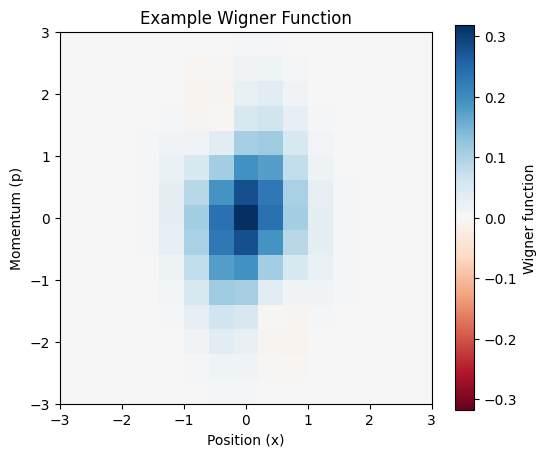

Corresponding parameters: [0.61916484 0.35110275 0.68687834 1.09542314 0.59173373 1.53250401
 4.78238179 1.23474692 0.80496169 3.         1.        ]


In [13]:
# Load data
data = np.load(DATA_FILE)
X = data['images']  # Shape: (num_samples, 15, 15)
y = data['params']   # Shape: (num_samples, 11)

print(f"Loaded data. Shapes: X={X.shape}, y={y.shape}")

# Example: Visualize first Wigner and its params
plt.figure(figsize=(6, 5))
plt.imshow(X[0].T, vmin=-1/np.pi, vmax=1/np.pi, cmap='RdBu', origin='lower',
           extent=[-PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF, -PHASE_SPACE_CUTOFF, PHASE_SPACE_CUTOFF])
plt.colorbar(label='Wigner function')
plt.xlabel('Position (x)')
plt.ylabel('Momentum (p)')
plt.title('Example Wigner Function')
plt.show()

print("Corresponding parameters:", y[0])

- Loading uses np.load, as in the image.
- Ensures X[i] and y[i] correspond to the same circuit (no de-sync risk).
- Visualization builds intuition: Look for negativities indicating non-Gaussianity.
- Why this format? Memory efficient, easy integration with PyTorch (as per image).

## Section 5: Prepare Data for PyTorch
Convert NumPy arrays to PyTorch tensors and create a DataLoader.
Python

In [14]:
# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (num_samples, 15, 15) – treat as 1-channel images
y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (num_samples, 11)

# Normalize Wigner images (optional: scale to [0,1] or standardize)
X_tensor = (X_tensor + 1/np.pi) / (2/np.pi)  # Scale from [-1/π, 1/π] to [0,1]

# Create TensorDataset and DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("DataLoader ready.")

DataLoader ready.


- Tensors: Float32 for NN compatibility.
- Normalization: Wigner values are bounded; scaling helps NN convergence.
- TensorDataset: Directly uses NumPy arrays, as highlighted in the image.
- Batch size 32: Standard; adjust for GPU/memory.

## Section 6: Define the Neural Network Model
Build a simple CNN for image-to-params regression.
Python

In [15]:
class WignerToParamsNN(nn.Module):
    def __init__(self):
        super(WignerToParamsNN, self).__init__()
        # CNN layers for feature extraction (input: 1x15x15)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 3 * 3, 128)  # After two pools: 15/4 ≈ 3.75 → adjust if needed
        self.fc2 = nn.Linear(128, 11)  # Output: 11 params
        
        # Activations
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dim: (batch, 1, 15, 15)
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate model
model = WignerToParamsNN()
print(model)

WignerToParamsNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=11, bias=True)
  (relu): ReLU()
)


- Architecture: CNN suits image inputs (Wigner pixels). Two conv layers extract features (e.g., shapes, negativities), followed by fully connected for regression.
- Output: 11 continuous values; no activation on final layer (regression).
- Customization: For better performance, add more layers or use ResNet. Constrain outputs (e.g., sigmoid for bounded params) in extensions.
- Input shape: Unsqueeze to add channel (grayscale image).

## Section 7: Train the Model
Set up optimizer, loss, and training loop.
Python

In [16]:
# Hyperparameters
EPOCHS = 50
LEARNING_RATE = 0.001

# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training loop
model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0.0
    for batch_X, batch_y in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f}")

print("Training complete.")

100%|██████████| 313/313 [00:01<00:00, 183.69it/s]


Epoch 1/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.17it/s]


Epoch 2/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.17it/s]


Epoch 3/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 165.81it/s]


Epoch 4/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 158.49it/s]


Epoch 5/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 164.28it/s]


Epoch 6/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 172.29it/s]


Epoch 7/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 170.78it/s]


Epoch 8/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 177.18it/s]


Epoch 9/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.14it/s]


Epoch 10/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 181.79it/s]


Epoch 11/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 181.34it/s]


Epoch 12/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 170.83it/s]


Epoch 13/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 178.83it/s]


Epoch 14/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 172.30it/s]


Epoch 15/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 167.04it/s]


Epoch 16/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 168.56it/s]


Epoch 17/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 168.99it/s]


Epoch 18/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 170.95it/s]


Epoch 19/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 166.19it/s]


Epoch 20/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 177.31it/s]


Epoch 21/50, Loss: nan


100%|██████████| 313/313 [00:02<00:00, 154.12it/s]


Epoch 22/50, Loss: nan


100%|██████████| 313/313 [00:02<00:00, 152.78it/s]


Epoch 23/50, Loss: nan


100%|██████████| 313/313 [00:02<00:00, 148.62it/s]


Epoch 24/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 161.19it/s]


Epoch 25/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 159.01it/s]


Epoch 26/50, Loss: nan


100%|██████████| 313/313 [00:02<00:00, 156.07it/s]


Epoch 27/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 167.43it/s]


Epoch 28/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 180.32it/s]


Epoch 29/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.72it/s]


Epoch 30/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 176.92it/s]


Epoch 31/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 177.52it/s]


Epoch 32/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 180.56it/s]


Epoch 33/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 187.82it/s]


Epoch 34/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.25it/s]


Epoch 35/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 186.03it/s]


Epoch 36/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.09it/s]


Epoch 37/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 179.09it/s]


Epoch 38/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.33it/s]


Epoch 39/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 185.94it/s]


Epoch 40/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 185.94it/s]


Epoch 41/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 182.26it/s]


Epoch 42/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 187.89it/s]


Epoch 43/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 187.81it/s]


Epoch 44/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 187.80it/s]


Epoch 45/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 181.98it/s]


Epoch 46/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 186.08it/s]


Epoch 47/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 188.03it/s]


Epoch 48/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 184.12it/s]


Epoch 49/50, Loss: nan


100%|██████████| 313/313 [00:01<00:00, 184.13it/s]

Epoch 50/50, Loss: nan
Training complete.


- Loss: MSE for continuous params. For photons (discrete), consider hybrid loss (e.g., CE on those columns).
- Optimizer: Adam is robust.
- Loop: Simple; add validation split for production.
- Evaluation: After training, test on holdout data (optional: split dataset 80/20).
- Constraints: Post-process outputs to bounds (e.g., clamp θ to [0, π/2]).

## Section 8: Evaluate and Predict
Test on a sample and visualize.
Python

In [17]:
# Example prediction
model.eval()
with torch.no_grad():
    sample_idx = 0
    pred = model(X_tensor[sample_idx].unsqueeze(0)).squeeze().numpy()
    true = y[sample_idx]

print("True params:", true)
print("Predicted params:", pred)

# Optional: Re-simulate with predicted params and compare Wigners (advanced exercise)

True params: [0.61916484 0.35110275 0.68687834 1.09542314 0.59173373 1.53250401
 4.78238179 1.23474692 0.80496169 3.         1.        ]
Predicted params: [nan nan nan nan nan nan nan nan nan nan nan]


Switch to eval mode (no gradients).
Compare true vs predicted.
For full eval: Compute MSE per param type or quantum fidelity (using MrMustard on predicted circuit).